# Labeling school budget data

Goal: Perform NLP on school budget data to predict accurate labels for the expenditure category using multiclass classification models from scikit learn. 

We will build a human-in-the-loop system by assigning a probability of labels to each line item.  

Author: Sushant N. More

Data from [DrivenData](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/data/) 

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [4]:
df_train = pd.read_csv('TrainingData.csv', index_col=0)

In [5]:
df_train.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,...,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,...,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    179964 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

In [8]:
df_train.tail()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
109283,Professional Development,ISPD,Shared Services,Non-School,Unspecified,Instructional Coach,Other Compensation/Stipend,NO_LABEL,PreK-12 Operating,WORKSHOP PARTICIPANT,...,NaN,STAFF DEV AND INSTR MEDIA,NaN,INST STAFF TRAINING SVCS,NaN,NaN,48.620000,NaN,GENERAL FUND,STAFF DEV AND INSTR MEDIA
102430,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,SALARIES OF PART TIME EMPLOYEE,...,NaN,NaN,0.00431,"TITLE II,D",NaN,PROFESSIONAL-INSTRUCTIONAL,128.824985,INSTRUCTIONAL STAFF TRAINING,NaN,INSTRUCTIONAL STAFF
413949,Parent & Community Relations,NO_LABEL,School Reported,School,NO_LABEL,Other,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.00000,NaN,NaN,PARENT/TITLE I,4902.290000,Misc,Schoolwide Schools,NaN
433672,Library & Media,Instruction,School on Central Budgets,Non-School,Unspecified,Librarian,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,ED RESOURCE SERVICES,NaN,NON-PROJECT,NaN,OFFICE/ADMINISTRATIVE SUPPORT,4020.290000,MEDIA SUPPORT SERVICES,NaN,INSTRUCTIONAL STAFF
415831,Substitute Compensation,Instruction,School Reported,School,Poverty,Substitute,Substitute Compensation,Non PreK,PreK-12 Operating,Salaries And Wages For Substitute Professionals,...,Inservice Substitute Teachers Grant Funded,School,NaN,Instruction,Instruction And Curriculum,CERTIFIED SUBSTITUTE,46.530000,Accelerated Education,"""Title Part A Improving Basic Programs""",MISCELLANEOUS


In [11]:
df_train.columns

Index([u'Function', u'Use', u'Sharing', u'Reporting', u'Student_Type',
       u'Position_Type', u'Object_Type', u'Pre_K', u'Operating_Status',
       u'Object_Description', u'Text_2', u'SubFund_Description',
       u'Job_Title_Description', u'Text_3', u'Text_4',
       u'Sub_Object_Description', u'Location_Description', u'FTE',
       u'Function_Description', u'Facility_or_Department', u'Position_Extra',
       u'Total', u'Program_Description', u'Fund_Description', u'Text_1'],
      dtype='object')

In [12]:
df_train.describe()

,FTE,Total
count,126071.000000,3.957220e+05
mean,0.426794,1.310586e+04
std,0.573576,3.682254e+05
min,-0.087551,-8.746631e+07
25%,0.000792,7.379770e+01
50%,0.130927,4.612300e+02
75%,1.000000,3.652662e+03
max,46.800000,1.297000e+08


FTE: Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.

Total: Stands for the total cost of the expenditure. This number tells us how much the budget item cost.

The variance in expenditure is high. Makes sense---some purchases are cheap, some are expensive. 

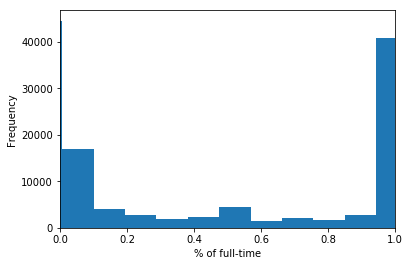

In [27]:
df_train['FTE'].dropna().plot(kind = 'hist', xlim = [0, 1], bins = 500);
plt.xlabel('% of full-time');

Bi-modal distribution! 

Making variables categorical.

First let's look at object variables. 

In [28]:
df_train.dtypes

Function                   object
Use                        object
Sharing                    object
Reporting                  object
Student_Type               object
Position_Type              object
Object_Type                object
Pre_K                      object
Operating_Status           object
Object_Description         object
Text_2                     object
SubFund_Description        object
Job_Title_Description      object
Text_3                     object
Text_4                     object
Sub_Object_Description     object
Location_Description       object
FTE                       float64
Function_Description       object
Facility_or_Department     object
Position_Extra             object
Total                     float64
Program_Description        object
Fund_Description           object
Text_1                     object
dtype: object

In [31]:
df_train.dtypes.value_counts()

object     23
float64     2
dtype: int64

The object types are slow and don't work well with ML algorithms.

For each of these rows, ERS attaches one label from each of 9 different categories as explained [here.](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/page/86/#labels_list)

Next we convert these labels into categories type.

In [32]:
labels = ['Function',
 'Use',
 'Sharing',
 'Reporting',
 'Student_Type',
 'Position_Type',
 'Object_Type',
 'Pre_K',
 'Operating_Status']

In [34]:
df_train[labels].head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating


In [35]:
df_train[labels].shape

(400277, 9)

In [36]:
categorize_label = lambda lab: lab.astype('category')

In [37]:
df_train[labels] = df_train[labels].apply(categorize_label, axis = 0)

In [39]:
df_train[labels].head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating


In [41]:
df_train[labels].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 9 columns):
Function            400277 non-null category
Use                 400277 non-null category
Sharing             400277 non-null category
Reporting           400277 non-null category
Student_Type        400277 non-null category
Position_Type       400277 non-null category
Object_Type         400277 non-null category
Pre_K               400277 non-null category
Operating_Status    400277 non-null category
dtypes: category(9)
memory usage: 6.5 MB


Counting unique labels

In [45]:
df_train[labels].nunique()

Function            37
Use                  8
Sharing              5
Reporting            3
Student_Type         9
Position_Type       25
Object_Type         11
Pre_K                3
Operating_Status     3
dtype: int64

In [46]:
type(df_train[labels].nunique())

pandas.core.series.Series

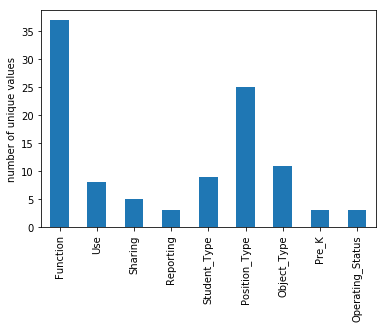

In [52]:
df_train[labels].nunique().plot(kind = 'bar');
plt.ylabel('number of unique values');